# cwutilits

# ⭐ Importing

In [52]:
!pip install opencv-python==4.5.5.64 --quiet


In [53]:
import os
import re
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import cv2
import torch.nn.functional as F
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from collections import Counter
from skimage import io, transform, img_as_ubyte, color
import torch
import torch.nn as nn
from sklearn import svm, metrics

from skimage.feature import hog

sns.set_style("whitegrid")

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_functions_scratch.ipynb', 'Code', '.DS_Store', 'Models', 'CW_Dataset', 'Video']


In [56]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

Functions to load Datasets: the first one returns an array containing all the images and another for the labels; The second one is similar but uses the Pytorch framework and returns a Dataset object.

In [6]:
image_folder = sorted(os.listdir('/content/train'))
    #generator to extract each image path
images_in_folder = [file for file in image_folder if file.endswith('.jpg')]

# 🏨 Helper Functions

In [7]:
def loadimages(root_dir, label_path):
    """Return an array of images and array of labels.

        Args:
            root_dir (string): Folder containing all the images.
            label_path (string): Path to text file containing image filename and labels in this order.
    """
    #import filenames and respective labels
    df = pd.read_csv(label_path,
                    delimiter=' ',
                    header=None,
                    names=['filename', 'label'])
    df.sort_values('filename', inplace=True)
    #import images
    images = []
    #!sort image folder
    image_folder = sorted(os.listdir(root_dir))
    #generator to extract each image path
    images_in_folder = (file for file in image_folder if file.endswith('.jpg'))
    count = 0 #index
    for imagepath, imagepath_label in zip(images_in_folder, (df['filename'])):
        count += 1 #check if filenames and filenames in labels list are equal
        if re.findall('\d+', imagepath) == re.findall('\d+', imagepath_label):
            image = io.imread(os.path.join(root_dir, imagepath))
            images.append(image)
        else:
            print(f'Found unmatched image file {imagepath} and label {imagepath_label} \
                at index {count}')
            pass

    return np.array(images), np.array(df['label'])


In [8]:
X, y = loadimages(
    '/content/train',
    '/content/labels/list_label_train.txt'
)

In [ ]:
#Get means
#array([146.67694409, 114.62696945, 102.31048249])
#std
#array([67.67195579, 61.77343565, 61.37423929])
x_means = X.mean(axis=(0, 1, 2))

In [9]:
class DatasetTorch(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, root_dir, label_path, transform=None):
        """
        Args:
            csv_file (string): Path to the text file with *exact image filenames* and  respective labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(
                                  label_path,
                                  delimiter=' ',
                                  header=None,
                                  names=['filename', 'label']
                                )
        self.root_dir = root_dir
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
            #idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.labels.iloc[idx, 1].ToTensor()
        #sample = {'image': image, 'label': label}

        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'label': label}

        return sample

In [10]:
#syntax to load and iterate over the images.
dataset_images = DatasetTorch('/content/test',
                   '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/list_label_test_edited.txt',
                   transform=transforms.Compose([
                    transforms.ToTensor(),                             
                    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])                             
                   ]
                       
                   ))

dataloader = DataLoader(dataset_images, batch_size=4,
                        shuffle=True, num_workers=0)


In [ ]:
#types of transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 🌏 EDA

Some Exploratory Data Analysis: First the training set

In [11]:
#Creating a ground truth dictionary
ground_truth = {
1: 'Surprise',
2: 'Fear',
3: 'Disgust',
4: 'Happiness',
5: 'Sadness',
6: 'Anger',
7: 'Neutral',}

In [ ]:
print(Counter(y))

Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281})


<function matplotlib.pyplot.tight_layout>

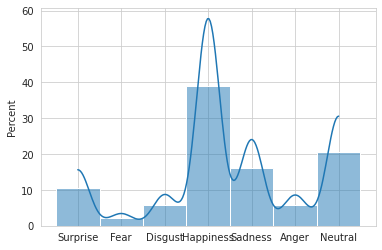

In [ ]:
#histogram for the training set
histogram = sns.histplot(y, discrete=True, kde=True, stat='percent',)
histogram.set_xticklabels(['0','Surprise','Fear','Disgust','Happiness','Sadness','Anger', 'Neutral'])
plt.tight_layout

Checking how representive the test dataset is

In [104]:
test_labels = pd.read_csv('/content/labels/list_label_test.txt',
                    delimiter=' ',
                    header=None,
                    names=['filename', 'label'])

In [ ]:
print(Counter(test_labels['label']))

Counter({4: 1185, 7: 680, 5: 478, 1: 329, 6: 162, 3: 160, 2: 74})


<function matplotlib.pyplot.tight_layout>

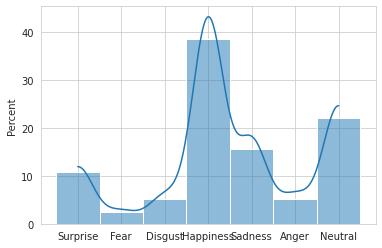

In [ ]:
histogram = sns.histplot(test_labels['label'], discrete=True, kde=True, stat="percent")
histogram.set_xticklabels(['0','Surprise','Fear','Disgust','Happiness','Sadness','Anger', 'Neutral'])
histogram.set(xlabel=None)
plt.tight_layout

Seems overall the test dataset follows the same distribution as the training dataset

Plotting some images from the training dataset

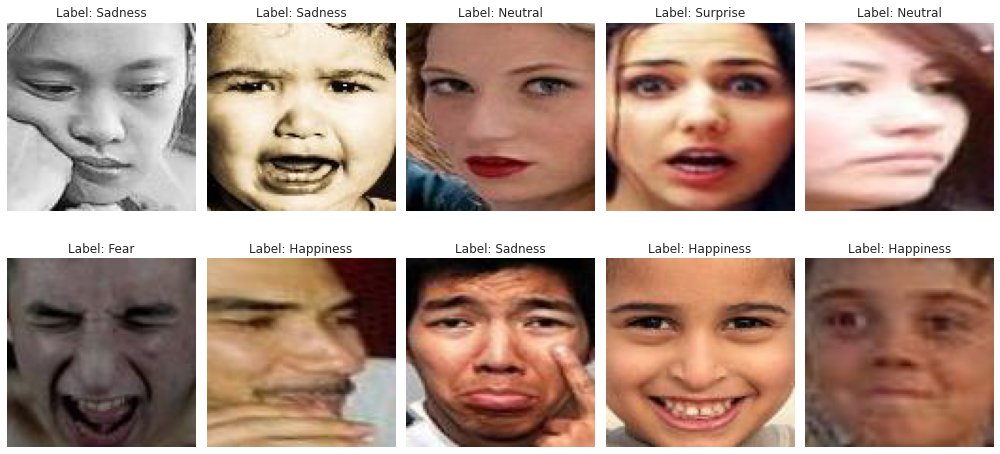

In [ ]:
#code adapted from Lab 07
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()
for image, i in zip(random.sample(range(12271), 10), range(10)):
    ax[i].imshow((X[image]))
    ax[i].set_title(f'Label: {ground_truth[y[image]]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

The images are aligned as the name suggests. However there are multiple orientation of the faces which could be good (more generalization) or bad (hard to find features in profiles).

In [ ]:
def plot4images(root_dir, label_path):
  #Get image file paths and import labels.
  image_folder = sorted(os.listdir(root_dir))
  df = pd.read_csv(label_path,
                  delimiter=' ',
                  header=None,
                  names=['filename', 'label']
                   )
  df.sort_values('filename', inplace=True)
  #randomly sample from dataframe and get index values.
  df = df.sample(4, axis =0)
  X, Y = [], []
  for i in df.index:
    y = df['label'][i]
    x = image_folder[i]
    X.append(x)
    Y.append(y)
  fig, axes = plt.subplots(1, 4, figsize=(7, 7), sharex=True, sharey=True)
  for image, i in ...:
    ax[i].imshow((image_folder[image]))
    ax[i].set_title(f'Label: {ground_truth[y[image]]}')
    ax[i].set_axis_off()
  fig.tight_layout()
  plt.show()





 # 🧪 TESTING

## 🛂 Importing Models

Importing HOG

## HOG

In [ ]:
#HOG
hog_list_xval = []
for image in X_test:
    hos_descriptor =  hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(1, 1),
                          feature_vector = True,
                          visualize=False,
                          transform_sqrt=True,
                          multichannel=True)
    hog_list_xval.append(hos_descriptor) 

dataset_hog_val = DatasetHog(hog_list_xval, y_val)
testloader = DataLoader(dataset_hog_val, batch_size=100,
                        shuffle=False, num_workers=0)

model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.float().to(device)
            y = y.to(device)

            y_pred = model(x)
            pred = torch.argmax(y_pred, dim=1)



Importing MLP

In [12]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    '''Forward pass'''
    #batch_size = x.shape[0]
    #x = x.view(batch_size, -1)
    return self.layers(x)

class DatasetHog(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, descriptors, labels, transform=None):
        """
        Args:
            labels : Array of labels.
            descriptors (string): Array of HOG descriptors.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.labels = pd.read_csv(
                                  #label_path,
                                  #delimiter=' ',
                                  #header=None,
                                  #names=['filename', 'label']
                                #)
        #self.root_dir = root_dir
        y = []
        for a in labels:
            x = a-1
            y.append(x)
        self.labels = y #convert labels to 0-6
        self.descriptors = descriptors
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.labels.iloc[idx, 0])
        #image = io.imread(img_name)
        descriptors = self.descriptors[idx]
        #label = self.labels.iloc[idx, 1]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(descriptors)
        
        return descriptors, label

In [306]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    '''Forward pass'''
    #batch_size = x.shape[0]
    #x = x.view(batch_size, -1)
    return self.layers(x)

class DatasetHog(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, descriptors, labels, transform=None):
        """
        Args:
            labels : Array of labels.
            descriptors (string): Array of HOG descriptors.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.labels = pd.read_csv(
                                  #label_path,
                                  #delimiter=' ',
                                  #header=None,
                                  #names=['filename', 'label']
                                #)
        #self.root_dir = root_dir
        y = []
        for a in labels:
            x = a-1
            y.append(x)
        self.labels = y #convert labels to 0-6
        self.descriptors = descriptors
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.labels.iloc[idx, 0])
        #image = io.imread(img_name)
        descriptors = self.descriptors[idx]
        #label = self.labels.iloc[idx, 1]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(descriptors)
        
        return descriptors, label

hog_list_xtest = []

for image in X_test:
    hos_descriptor =  hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(1, 1),
                          feature_vector = True,
                          visualize=False,
                          transform_sqrt=True,
                          multichannel=True)
    hog_list_xtest.append(hos_descriptor) 

hog_list_xval = []


dataset_hog_val = DatasetHog(hog_list_xtest, y_test)
testloader = DataLoader(dataset_hog_val, batch_size=100,
                        shuffle=False, num_workers=0)



model = MLP(1296, 7)

device = torch.device('cpu')
PATH = '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/mlp-hog.pt'
model.load_state_dict(torch.load(PATH, map_location=device))
p = []
with torch.no_grad():

      for (x, y) in tqdm(testloader, desc="Evaluating", leave=False):

          x = x.float().to(device)
          y = y.to(device)

          y_pred = model(x)
          pred = torch.argmax(y_pred, dim=1)
          p.append(pred.cpu().numpy())

pout = np.concatenate(p).ravel().tolist()



In [186]:
y_ = []
for a in y_test:
    x = a-1
    y_.append(x)

In [188]:
f1_score_MLP = metrics.f1_score(y_,
                                  pout,
                                  average=None)

In [ ]:
0.56886228 0.39726027 0.26031746 0.77208153 0.4953271 0.49180328 0.5862069

<BarContainer object of 7 artists>

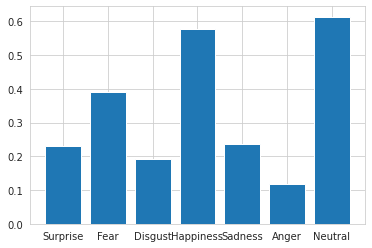

In [232]:
labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
plt.bar(labels,f1_score_MLP )

In [187]:
metrics.balanced_accuracy_score(y_, pout)

0.33812257671565576

CNN

In [40]:
class ConvNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*22*22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*22*22)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DatasetTorch(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, root_dir, label_path, transform=None):
        """
        Args:
            csv_file (string): Path to the text file with *exact image filenames* and  respective labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.labels = pd.read_csv(
                                  #label_path,
                                  #delimiter=' ',
                                  #header=None,
                                  #names=['filename', 'label']
                                #)
        #self.root_dir = root_dir
        y=[]
        for a in label_path:
            x = a-1
            y.append(x)
        self.labels = label_path
        self.root_dir = root_dir
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
            #idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.labels.iloc[idx, 0])
        #image = io.imread(img_name)
        image = self.root_dir[idx]
        #label = self.labels.iloc[idx, 1]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(image)
        
        return image, label
dataset_images_val = DatasetTorch(X_test,
                   y_test,
                   transform=transforms.Compose([
                    transforms.ToTensor(),                             
                    transforms.Normalize([0.5752, 0.4495, 0.4012], [0.2654, 0.2422, 0.2407])                             
                   ]
                       
                   ))


test_loader = DataLoader(dataset_images_val, batch_size=32,
                        shuffle=True, num_workers=0)

model_CNN = ConvNet1()
device = torch.device('cpu')
model_CNN.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_model.pt'), map_location=device))


#calculate = test(model, test_loader)





<All keys matched successfully>

In [298]:
model

ConvNet1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [294]:
def test(model, test_loader):
    model.eval()

    predictions = []
    targets = []
    
    # Run the model on some test examples
    with torch.no_grad():
        correct, total, cumu_loss = 0, 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Get logits
            outputs = model(images)
            # Calculate loss
            #Get predictions
            _, predicted = torch.max(outputs.data, 1)
            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()

            # Save predictions
            pred = predicted.detach().cpu().detach().numpy()
            labels_list = labels.detach().cpu().detach().numpy()

            #Flatten
            for i in range(len(pred)):
              predictions.append(pred[i])
              targets.append(labels_list[i])
            

        return np.concatenate(predictions).ravel().tolist(), np.concatenate(target).ravel().tolist()

In [ ]:
X

In [300]:
def test(model, test_loader, logging=False):
    model.eval()

    predictions = []
    targets = []
    
    # Run the model on some test examples
    with torch.no_grad():
        correct, total, cumu_loss = 0, 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Get logits
            outputs = model(images)
            # Calculate loss
            #Get predictions
            _, predicted = torch.max(outputs.data, 1)

            predictions.append(predicted.cpu().numpy())
            targets.append(labels.cpu().numpy())

        return np.concatenate(predictions).ravel().tolist(), np.concatenate(target).ravel().tolist()


In [209]:
#
predictions, target = test(model, test_loader)
pout_cnn = np.concatenate(predictions).ravel().tolist()
targets_cnn = np.concatenate(target).ravel().tolist()


In [223]:
target_q = []
for a in targets_cnn:
    x = a - 1
    target_q.append(x)

In [47]:
CNN_score

NameError: ignored

In [227]:
CNN_score = metrics.balanced_accuracy_score(target_q, pout_cnn)
f1_score_CNN = metrics.f1_score(target_q,
                                  pout_cnn,
                                  average=None)

<BarContainer object of 7 artists>

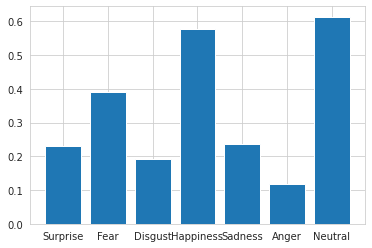

In [233]:
labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
plt.bar(labels,f1_score_CNN )

In [228]:
print(f'the F1 scores are {f1_score_MLP} and the average accuracy is {CNN_score}')

the F1 scores are [0.22992126 0.39189189 0.19090909 0.57692308 0.23673469 0.11869436
 0.61356932] and the average accuracy is 0.3428343147296459


## SIFT-SVM

In [57]:
X_test, y_test = loadimages('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/test', '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/list_label_test_edited.txt')

In [58]:
from joblib import dump, load


In [59]:
import cv2

In [65]:
kmeans = load('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_kmeans.joblib')
svm = load('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_model.joblib')

sift = cv2.SIFT_create()
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(70)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = svm.predict(hist_array).tolist()






In [61]:
hist_array = np.vstack(hist_list)

In [62]:
y_pred = svm.predict(hist_array).tolist()


In [68]:
CNN_score

0.13799142667936537

In [67]:
CNN_score = metrics.balanced_accuracy_score(y_test, y_pred)


In [66]:
f1_score = metrics.f1_score(y_test,
                                  y_pred,
                                  average=None)

In [159]:
f1_score

array([0.12654321, 0.02673797, 0.04739336, 0.22138837, 0.15949367,
       0.09681228, 0.12226067])

In [ ]:
labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
plt.bar(labels,f1_score )

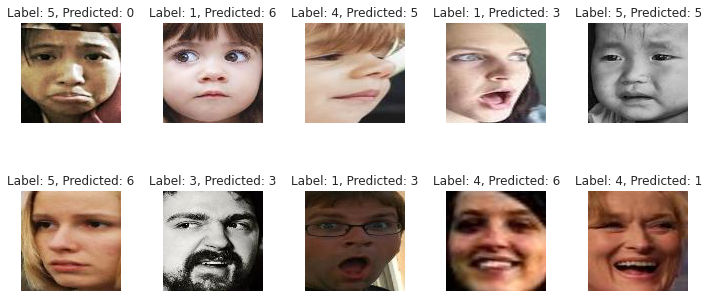

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i, :, :])
    ax[i].set_title(f'Label: {y_test[i]}, Predicted: {pout_cnn[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [157]:
metrics.balanced_accuracy_score(y_test, y_pred)

0.13799142667936537

In [247]:
EmotionRecognition('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/test,
                    'SIFT-SVM',
                   '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/list_label_test_edited.txt')

SyntaxError: ignored

In [245]:
def EmotionRecognition(path_to_testset: str,
                       model_type: str,
                       label_path: str):
    # Read the labels
    df = pd.read_csv(label_path,
                    delimiter=' ',
                    header=None,
                    names=['filename', 'label'])

    ground_truth = {
        0: 'Surprise',
        1: 'Fear',
        2: 'Disgust',
        3: 'Happiness',
        4: 'Sadness',
        5: 'Anger',
        6: 'Neutral', }

    # Sort the table by filename
    df.sort_values('filename', inplace=True)

    # Read and sort the directory for test images as well
    image_folder = sorted(os.listdir(path_to_testset))
    # Filter only images
    images_in_folder = [file for file in image_folder if file.endswith('.jpg')]

    # Get 4 random labels
    sample = df.sample(4)

    #image = io.imread(os.path.join(root_dir, imagepath))
    #images.append(image)

    X, Y = [], []
    for i in sample.index:
        y = df['label'][i]
        x = io.imread(os.path.join(root_dir, imagepath[i]))
        X.append(x)
        Y.append(y)

    if model_type == 'SIFT-SVM':
        for i in range(len(X_test)):
            img = img_as_ubyte(color.rgb2gray(X_test[i]))
            kp, des = sift.detectAndCompute(img, None)

            if des is not None:
                hist = np.zeros(70)

                idx = kmeans.predict(des)

                for j in idx:
                    hist[j] = hist[j] + (1 / len(des))

                # hist = scale.transform(hist.reshape(1, -1))
                hist_list.append(hist)

            else:
                hist_list.append(None)

        # Remove potential cases of images with no descriptors
        idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
        hist_list = [hist_list[i] for i in idx_not_empty]
        # y_test = [y_test[i] for i in idx_not_empty]
        hist_array = np.vstack(hist_list)

        y_pred = svm.predict(hist_array).tolist()
        fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/list_label_test_edited.txt',
                delimiter=' ',
                header=None,
                names=['filename', 'label'])

root_dir = '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/test'
ground_truth = {
    0: 'Surprise',
    1: 'Fear',
    2: 'Disgust',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Anger',
    6: 'Neutral', }

# Sort the table by filename
df.sort_values('filename', inplace=True)

# Read and sort the directory for test images as well
image_folder = sorted(os.listdir('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/CW_Dataset/test'))
# Filter only images
images_in_folder = [file for file in image_folder if file.endswith('.jpg')]

# Get 4 random labels
sample = df.sample(4)

#image = io.imread(os.path.join(root_dir, imagepath))
#images.append(image)

X, Y = [], []
for i in sample.index:
    y = df['label'][i]
    x = io.imread(os.path.join(root_dir, images_in_folder[i]))
    X.append(x)
    Y.append(y)

#if model_type == 'SIFT-SVM':
hist_list = []
for i in range(len(X)):
    img = img_as_ubyte(color.rgb2gray(X[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(70)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
# y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

y_pred = svm.predict(hist_array).tolist()
fig, axes = plt.subplots(1, 4, figsize=(17, 4), sharex=True, sharey=True)
ax = axes.ravel()
for  i in range(4):
    ax[i].imshow((X[i]))
    ax[i].set_title(f'Target: {ground_truth[Y[i]]}\nLabel: {ground_truth[y_pred[i]]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

NameError: ignored

In [ ]:
for image, i in ran:
    ax[i].imshow((X[image]))
    ax[i].set_title(f'Label: {ground_truth[y[image]]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [262]:
y_pred

[2, 3, 3, 3]

In [254]:
kmeans = load('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_kmeans.joblib')
svm = load('/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/svm_sift_model.joblib')

In [258]:
for i in range(len(X)):
    img = img_as_ubyte(color.rgb2gray(X[i]))
    kp, des = sift.detectAndCompute(img, None)
    print(kp)

(<KeyPoint 0x7f503f006c60>, <KeyPoint 0x7f503f006990>, <KeyPoint 0x7f50585e3330>, <KeyPoint 0x7f50585e3120>, <KeyPoint 0x7f50585e3cf0>, <KeyPoint 0x7f50585e3390>, <KeyPoint 0x7f50585e3720>, <KeyPoint 0x7f50585e3600>, <KeyPoint 0x7f50585e3e10>, <KeyPoint 0x7f50585e3840>, <KeyPoint 0x7f50585e3d20>, <KeyPoint 0x7f50585e35d0>, <KeyPoint 0x7f50585e3c00>, <KeyPoint 0x7f50585e3f00>, <KeyPoint 0x7f50585e3e70>, <KeyPoint 0x7f50585e3f90>, <KeyPoint 0x7f50585e32d0>, <KeyPoint 0x7f50585e34b0>, <KeyPoint 0x7f50585e3150>, <KeyPoint 0x7f50585e3fc0>, <KeyPoint 0x7f50585e3d80>, <KeyPoint 0x7f50585e3e40>, <KeyPoint 0x7f50585c62a0>, <KeyPoint 0x7f50585c6060>, <KeyPoint 0x7f50585c6210>, <KeyPoint 0x7f50585c60f0>, <KeyPoint 0x7f50585c62d0>, <KeyPoint 0x7f50585c6cc0>, <KeyPoint 0x7f50585c6ea0>, <KeyPoint 0x7f50585c6e70>, <KeyPoint 0x7f50585c6180>, <KeyPoint 0x7f50585c6270>, <KeyPoint 0x7f50585c6570>, <KeyPoint 0x7f50585c64b0>, <KeyPoint 0x7f50585c6cf0>, <KeyPoint 0x7f50585c6d20>, <KeyPoint 0x7f50585c63f0>, 

In [ ]:
X

In [284]:
ground_truth

{0: 'Surprise',
 1: 'Fear',
 2: 'Disgust',
 3: 'Happiness',
 4: 'Sadness',
 5: 'Anger',
 6: 'Neutral'}

[4, 4, 4, 5]

In [303]:
Y

[4, 4, 4, 5]

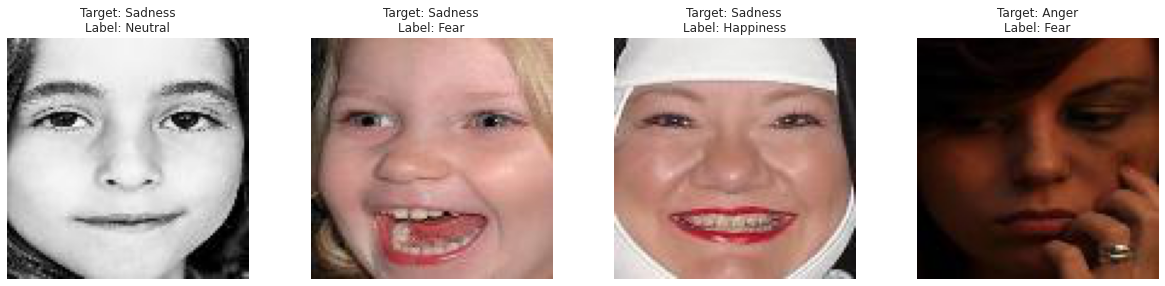

In [288]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4), sharex=True, sharey=True)
ax = axes.ravel()
for  i in range(4):
    ax[i].imshow((X[i]))
    ax[i].set_title(f'Target: {ground_truth[Y[i]]}\nLabel: {ground_truth[y_pred[i]]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [318]:
def hog_test4(X, Y, model):
    hog_list_xtest = []
    model_hog = model
    X_test = X
    y_test = Y
    for image in X_test:
        hos_descriptor =  hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(1, 1),
                              feature_vector = True,
                              visualize=False,
                              transform_sqrt=True,
                              multichannel=True)
        hog_list_xtest.append(hos_descriptor) 

    hog_list_xval = []

    dataset_hog_val = DatasetHog(hog_list_xtest, y_test)
    testloader_hog = DataLoader(dataset_hog_val, batch_size=100,
                            shuffle=False, num_workers=0)
    model.eval()
    with torch.no_grad():

      for (x, y) in tqdm(testloader_hog, desc="Evaluating HOG", leave=False):

          x = x.float().to(device)
          #y = y.to(device)

          y_pred = model_hog(x)
          pred = torch.argmax(y_pred, dim=1)
          p.append(pred.cpu().numpy())

    return pout, y 

In [ ]:
hog_list_xtest = []
p = []
model_hog = model
X_test = X
y_test = Y
for image in X:
    print(image)
    hos_descriptor =  hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(1, 1),
                          feature_vector = True,
                          visualize=False,
                          transform_sqrt=True,
                          multichannel=True)
    hog_list_xtest.append(hos_descriptor) 

hog_list_xval = []

dataset_hog_val = DatasetHog(hog_list_xtest, y_test)
testloader_hog = DataLoader(dataset_hog_val, batch_size=4,
                        shuffle=False, num_workers=0)
model.eval()
with torch.no_grad():

  for (x, y) in testloader_hog:

      x = x.float().to(device)
      #y = y.to(device)

      y_pred = model_hog(x)
      pred = torch.argmax(y_pred, dim=1)
      p.append(pred.cpu().numpy())

return p, y 

In [32]:
y

tensor([6, 2, 3, 3])

In [29]:
len(pout)

NameError: ignored

In [ ]:
from tdqm

In [21]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    '''Forward pass'''
    #batch_size = x.shape[0]
    #x = x.view(batch_size, -1)
    return self.layers(x)

class DatasetHog(Dataset):
    #adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """Images dataset for pytorch."""

    def __init__(self, descriptors, labels, transform=None):
        """
        Args:
            labels : Array of labels.
            descriptors (string): Array of HOG descriptors.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.labels = pd.read_csv(
                                  #label_path,
                                  #delimiter=' ',
                                  #header=None,
                                  #names=['filename', 'label']
                                #)
        #self.root_dir = root_dir
        y = []
        for a in labels:
            x = a-1
            y.append(x)
        self.labels = y #convert labels to 0-6
        self.descriptors = descriptors
        self.transform = transform
        #self.image_path = sorted(os.listdir(root_dir))
        #self.transform = transforms.Compose(
                                #[transforms.Normalize(),
                                #transforms.ToTensor()]
                                #)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,
                                #self.labels.iloc[idx, 0])
        #image = io.imread(img_name)
        descriptors = self.descriptors[idx]
        #label = self.labels.iloc[idx, 1]
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(descriptors)
        
        return descriptors, label

In [23]:
model = MLP(1296, 7)
device = torch.device('cpu')
PATH = '/content/drive/MyDrive/Computer Vision Coursework/CW_Folder_PG/Models/mlp-hog.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [24]:
hog_test4(X, Y, model)

NameError: ignored

### HOG DONE

In [33]:
def hog4(X, Y, model):
    hog_list_xtest = []
    p = []
    model_hog = model
    X_test = X
    y_test = Y
    for image in X:
        print(image)
        hos_descriptor =  hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(1, 1),
                              feature_vector = True,
                              visualize=False,
                              transform_sqrt=True,
                              multichannel=True)
        hog_list_xtest.append(hos_descriptor) 

    hog_list_xval = []

    dataset_hog_val = DatasetHog(hog_list_xtest, y_test)
    testloader_hog = DataLoader(dataset_hog_val, batch_size=4,
                            shuffle=False, num_workers=0)
    model.eval()
    with torch.no_grad():
      y_ = []
      for (x, y) in testloader_hog:

          x = x.float().to(device)
          #y = y.to(device)

          y_pred = model_hog(x)
          pred = torch.argmax(y_pred, dim=1)
          p.append(pred.cpu().numpy())
          y_.pred(y)

    return p, y 

In [46]:
y

tensor([6, 2, 3, 3])

## CNN

In [44]:
a = test4_CNN(X, Y, model_CNN)

In [45]:
a

[4, 3, 3, 3]

In [ ]:
model_CNN

In [43]:
def test4_CNN(X, Y, model):
    model.eval
    pred_list = []
    for i in X:
      model.eval()
      transform_ = transforms.Compose([
                          transforms.ToTensor(),                             
                          transforms.Normalize([0.5752, 0.4495, 0.4012], [0.2654, 0.2422, 0.2407])                             
                      ])
      i = transform_(i)
      with torch.no_grad():
          logits = model(i)
          _, predicted = torch.max(logits, 1)
          predicted = predicted.numpy()[0]
          pred_list.append(predicted)
    return pred_list

In [37]:
model_CNN = ConvNet1()
device = torch.device('cpu')
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_model.pt'), map_location=device))


NameError: ignored